## Load Dependancies

In [5]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params
from scipy import stats
import statsmodels.api as sm

from sklearn.manifold import MDS
import pdb

import warnings
warnings.filterwarnings("ignore")



In [6]:
atlas = 'wang'


#load atlast name and roi labels
atlas_info = params.load_atlas_info(atlas)
group_params = params.load_group_params('infant')

sub_info = group_params.sub_list
subs2analyze = sub_info[(sub_info[f'{atlas}_exclude'] != 1) & (sub_info[f'{atlas}_ts'] == 1)]
group = 'infant'

age_bins = [26,33, 38,42,46]
age_groups = ['Pre-Term','Early-Term','Term','Post-Term']



#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
#roi_labels['network'] = ['Occipital']*6 + ['Ventral']*5 + ['Lateral']*6 + ['Dorsal']*7

networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', '#00fd00']

roi_labels = atlas_info.roi_labels

#expand roi labels to include hemis
all_rois = []
all_networks = []


all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




### Identify infants with poor signal

Essentially, exclude any subs who are <2 SDs below the mean of the group

In [4]:
#load noise ceiling data
noise_df = pd.read_csv(f'{group_params.out_dir}/derivatives/noise_ceiling/infant_{atlas}_split_half_reliability.csv')

#add age column
noise_df['age'] = (noise_df['scan_age'] - noise_df['birth_age'])*7

#add age group column
noise_df['age_group'] = np.nan

for i in range(len(age_bins)-1):
    noise_df.loc[(noise_df['scan_age'] >= age_bins[i]) & (noise_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['ses'].isin(subs2analyze['ses'])]


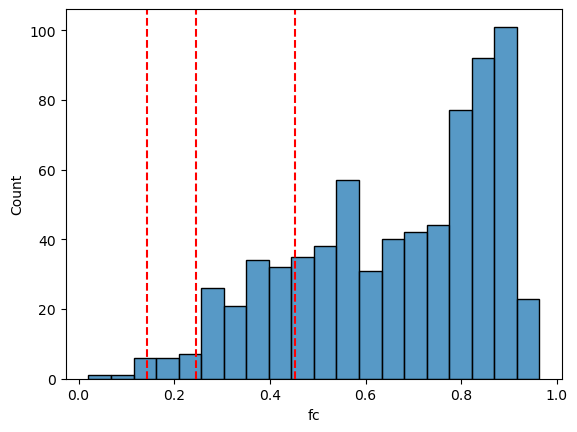

In [4]:
#compute average noise ceiling for each subject
noise_df_mean = noise_df.groupby(['sub', 'ses','age_group']).mean(numeric_only=True).reset_index()

#plot histogram of noise ceiling
plt.figure()
sns.histplot(noise_df_mean['fc'], bins=20)
#add line at SD = 1, 2
#compute SD of noise ceiling
sd = np.std(noise_df_mean['fc'])
mean = np.mean(noise_df_mean['fc'])
plt.axvline(x=mean- sd, color='r', linestyle='--')
plt.axvline(x=mean- (2*sd), color='r', linestyle='--')
plt.axvline(x=mean- (2.5*sd), color='r', linestyle='--')

In [5]:
#print how many subs are below 1, 2, 2.5 SD
print(f'Number of subs below 1 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-sd])}')
print(f'Number of subs below 2 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2*sd)])}')
print(f'Number of subs below 2.5 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2.5*sd)])}')

#print number of subs of each age group below 1, 2, 2.5 SD
for age_group in age_groups:
    print(f'Number of {age_group} subs below 2 SD: {len(noise_df_mean[(noise_df_mean["fc"] < mean-(2*sd)) & (noise_df_mean["age_group"] == age_group)])} out of {len(noise_df_mean[noise_df_mean["age_group"] == age_group])}')
    

Number of subs below 1 SD: 137
Number of subs below 2 SD: 18
Number of subs below 2.5 SD: 6
Number of Pre-Term subs below 2 SD: 1 out of 43
Number of Early-Term subs below 2 SD: 4 out of 125
Number of Term subs below 2 SD: 7 out of 358
Number of Post-Term subs below 2 SD: 6 out of 188


In [6]:
#mark subs with noise ceiling below 2 SD in sub_info sheet
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].astype(str)
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].replace('nan', '')

for sub in noise_df_mean[noise_df_mean['fc'] < mean-(2*sd)]['sub']:
    sub_info.loc[sub_info['participant_id'] == sub, f'{atlas}_exclude'] = '1'

In [8]:
#save sub_info sheet
sub_info.to_csv(f'{git_dir}/participants_dhcp.csv', index=False)

### Plot Noise ceilings for each age group

Text(0.5, 0, 'Age Group')

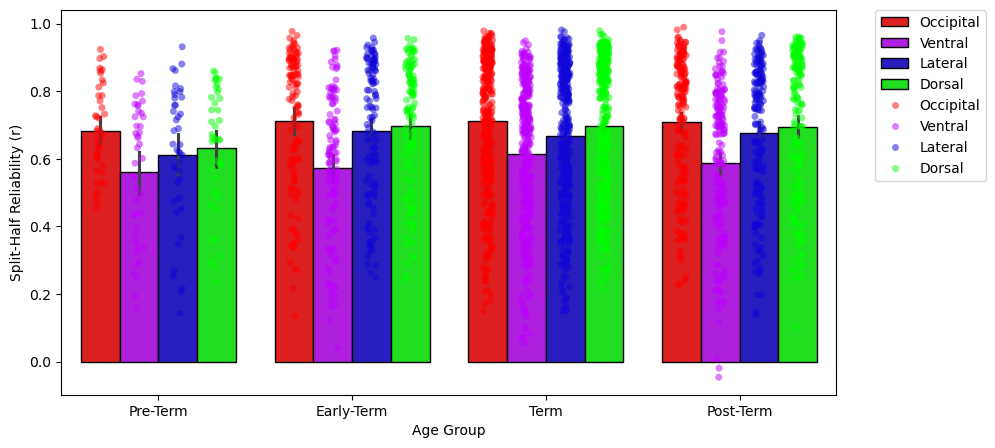

In [5]:


#set network and age_group as categorical
noise_df['network'] = pd.Categorical(noise_df['network'], categories=networks, ordered=True)
noise_df['age_group'] = pd.Categorical(noise_df['age_group'], categories=age_groups, ordered=True)

#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['sub'].isin(subs2analyze['participant_id'])]



#summarize data by network and age group
noise_df = noise_df.groupby(['sub', 'ses', 'network', 'age_group']).mean(numeric_only=True).reset_index()





#plot noise ceiling by network and age group as bar graphs
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='fc', data=noise_df,hue='network', palette=network_colors, edgecolor='k', errorbar=('ci',95))
#add individual data points
sns.stripplot(x='age_group', y='fc', data=noise_df, hue='network', dodge=True, palette=network_colors, edgecolor='k', alpha=0.5)

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#set y axis label 
plt.ylabel('Split-Half Reliability (r)')

#set x axis label
plt.xlabel('Age Group')

<Axes: xlabel='age_group', ylabel='fc'>

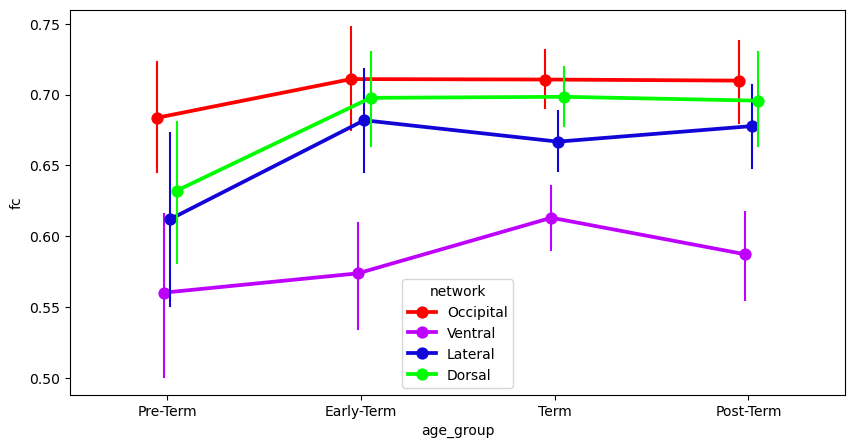

In [6]:
#plot noise ceiling as point_plot
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='fc', data=noise_df, hue='network', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

### Compute Arealization Index

In [16]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#load adjacency file for rois
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')


#### Compute Arealization overall

In [17]:
def create_mat(df,col = 'fc', roi_labels=all_rois):
    #create empty matrix to store infant data
    mat = np.zeros((len(roi_labels), len(roi_labels)))

    #fill in infant matrix with infant data
    for i, roi1 in enumerate(roi_labels):
        for j, roi2 in enumerate(roi_labels):
            mat[i,j] = df[(df['roi1'] == roi1) & (df['roi2'] == roi2)][col].values[0]

    return mat

def plot_fc_matrix(corr_mat, roi_labels, file_name):
    #make diagonal to nans
    corr_mat = np.array(corr_mat)
    print(corr_mat.shape)
    #corr_mat = np.fill_diagonal(corr_mat, np.nan)

    #extract upper triangle
    corr_mat = np.tril(corr_mat)

    #set 0s to nans
    corr_mat[corr_mat == 0] = np.nan

    
    sns.heatmap(corr_mat, cmap= 'coolwarm', cbar =False)
    #make bigger 
    plt.gcf().set_size_inches(12,12)

    #add labels from all_labels
    plt.xticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 90)
    plt.yticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 0)
    

    #make background black
    ax = plt.gca()

    #make plot square
    ax.set_aspect('equal', 'box')

    #make background white
    ax.set_facecolor('white')

    

    if file_name is not None:
        plt.savefig(f'{git_dir}/figures/{file_name}.png')    

    plt.show()
    plt.pause(.001)



In [18]:
#extract day 1 data
# extract infants that were scanned on day 1
curr_df = sub_df[sub_df['age'] <= 1]
curr_df_median = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2', 'roi_similarity', 'hemi_similarity']).median(numeric_only=True).reset_index()

#extract hemi_similarity == diff
curr_df_diff = curr_df_median[curr_df_median['hemi_similarity'] == 'diff']

#average by roi1 and roi2, roi_similairty
curr_df_diff = curr_df_diff.groupby(by=['roi1', 'roi2', 'roi_similarity']).mean(numeric_only=True).reset_index()

#extract fc matrix
fc_mat = create_mat(curr_df_diff, col = 'fc', roi_labels = adj_rois['label'].to_list())
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = adj_rois['label'].to_list(), index = adj_rois['label'].to_list())


(24, 24)


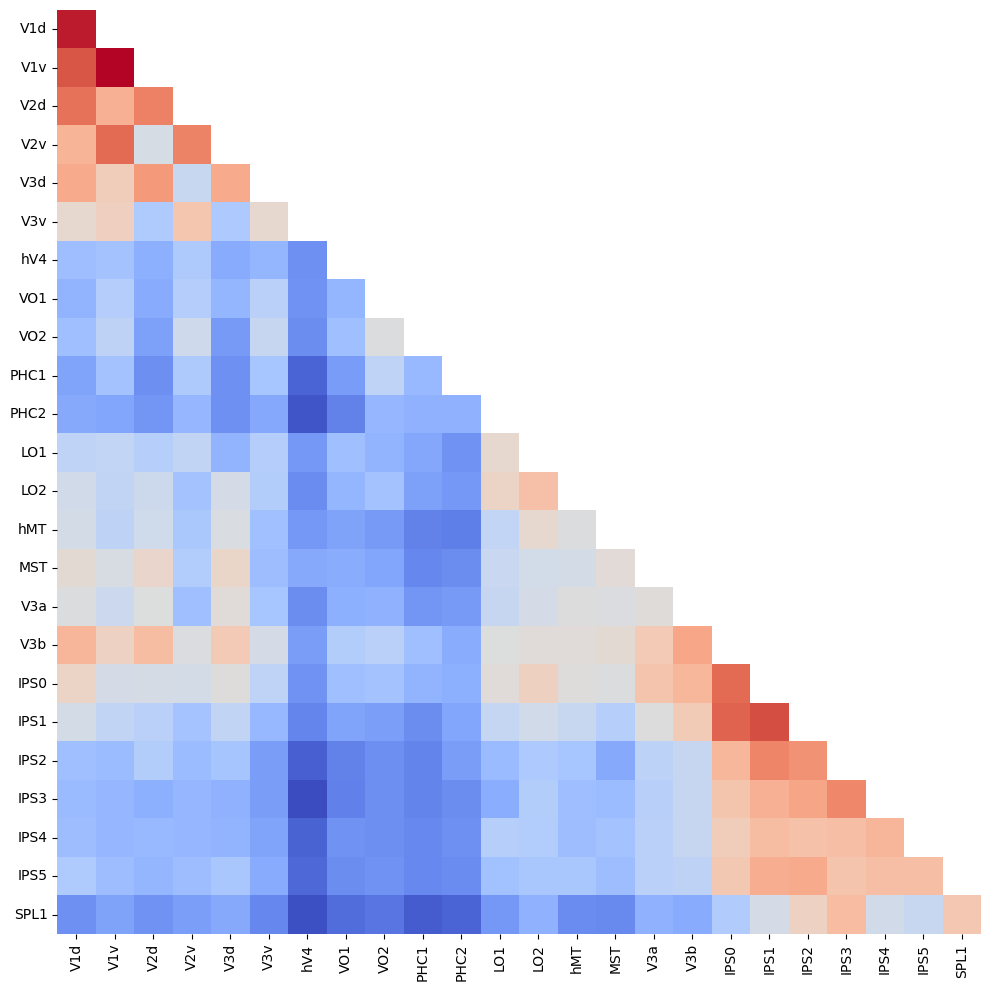

In [19]:

#create heatmap
plot_fc_matrix(fc_mat_df, adj_rois['label'].to_list(), 'infant_day1_arealization')


#### Plot Arealization across types

In [36]:
#group by ROIs
df_roi_summary = sub_df.groupby(['sub', 'ses', 'roi1','roi2','hemi_similarity','roi_similarity','network_similarity']).mean(numeric_only=True).reset_index()
df_roi_summary = df_roi_summary[df_roi_summary['hemi_similarity'] == 'diff']

#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
df_roi_summary['roi_similarity_adj'] = np.nan



for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj1) | (df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj2),
                                                     'Adjacent', df_roi_summary['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    df_roi_summary['roi_similarity_adj'] = np.where(df_roi_summary['roi1'] == df_roi_summary['roi2'], 'Same\nArea', df_roi_summary['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] != df_roi_summary['roi2']) & (df_roi_summary['roi_similarity_adj'] != 'Adjacent') & (df_roi_summary['roi_similarity_adj'] != 'same'),
                                                     'Distal', df_roi_summary['roi_similarity_adj'])


In [37]:
#group by roi_similarity_adj
df_roi_summary = df_roi_summary.groupby(['sub', 'ses', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

##### Plot as bars

Text(0, 0.5, 'Cross-Hemisphere\nCorrelation')

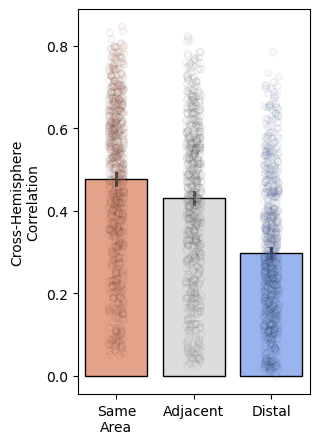

In [40]:
comp_order = ['Same\nArea', 'Adjacent', 'Distal']

#make roi_network_similarity a categorical variable
df_roi_summary['roi_similarity_adj'] = pd.Categorical(df_roi_summary['roi_similarity_adj'], categories=comp_order, ordered=True)

#plot arealization by roi_network_similarity
plt.figure()
sns.barplot(x='roi_similarity_adj', y='fc', data=df_roi_summary, palette='coolwarm_r', edgecolor='k', errorbar=('ci',95))

#add individual data points with same colors as bar plot
sns.stripplot(x='roi_similarity_adj', y='fc', data=df_roi_summary, marker = 'o',palette='coolwarm_r', edgecolor='k', linewidth=1,alpha=.05)


#change figure size
plt.gcf().set_size_inches(3,5)

#remove x axis label
plt.xlabel('')
#rename Y-axis label
plt.ylabel('Cross-Hemisphere\nCorrelation')

##### PLot as violins

network1   roi_similarity
Occipital  same              0.605713
           diff              0.485262
Name: fc, dtype: float64
network1  roi_similarity
Ventral   same              0.341730
          diff              0.283769
Name: fc, dtype: float64
network1  roi_similarity
Lateral   same              0.456665
          diff              0.412791
Name: fc, dtype: float64
network1  roi_similarity
Dorsal    same              0.550340
          diff              0.444132
Name: fc, dtype: float64


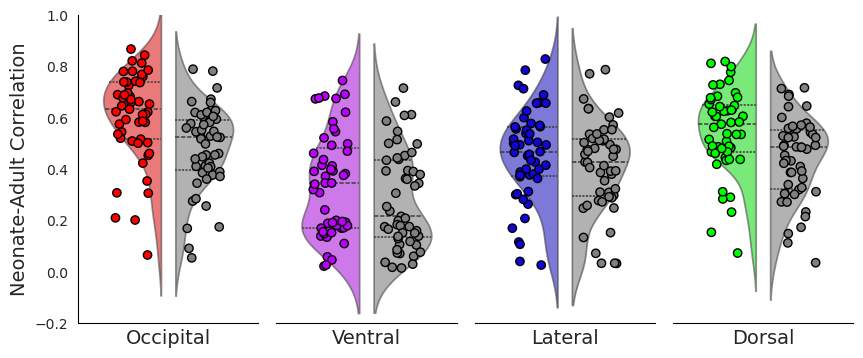

In [64]:
'''
plot sub data at network level
This version compares same to same networks

'''


#remove same region comparisons from df_summary_grouped and df_noise_grouped


#set network order
network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
comp_order = ['same','diff']
#comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


#set network order as categorical and level order
df_network_summary['roi_similarity'] = pd.Categorical(df_network_summary['roi_similarity'], categories=comp_order, ordered=True)
#df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


#create list of 12 gray colors
network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['#00fd00', 'gray']]

#loop through networks and create subplot for each
#set subplot size
fig,ax = plt.subplots(1,4,figsize=(10,4),sharey=False)
for i in range(0,len(network_order)):
    #print(network_order[i])
    curr_data = df_network_summary[(df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'same')]
    
    print(curr_data.groupby(['network1','roi_similarity'])['fc'].mean())
    
        
    #add horizontal line at mean
    #ax[i].axhline(y=curr_data[curr_data['roi_similarity']=='same']['corr'].mean(), color = 'r', linestyle = '--')
    
    #plot summary_df
    sns.violinplot(data=curr_data, x= 'network1', y= 'fc', hue='roi_similarity',
                   split = True,gap = .2, alpha = .6, inner = 'quart', palette = network_colors[i], ax = ax[i])

    #set alpha for all artists
    #for artist in ax[i].artists:
    #    artist.set_alpha(.5)

    sns.stripplot(data = curr_data,  x= 'network1', y= 'fc', hue = 'roi_similarity', 
                  dodge=True,edgecolor = 'black', alpha = 1, linewidth=1,jitter = .2, size = 6,
                    palette = network_colors[i], ax = ax[i])




    
    #increase font size of x and y ticks
    #plt.xticks(fontsize = 10)
    #plt.yticks(fontsize = 10)

    #set y limits
    ax[i].set_ylim([-.2,1])

    #add y label
    if i == 0:

        ax[i].set_ylabel('Neonate-Adult Correlation', fontsize = 14)
        #make axes black
        ax[i].spines['left'].set_color('k')
        



    else:
        
        #remove y label
        ax[i].set_ylabel('')
        #remove y ticks
        ax[i].set_yticks([])
        #remove y tick labels
        ax[i].set_yticklabels([])
        #remove y axis line
        ax[i].spines['left'].set_visible(False)

    #remove x ticks and labels
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    
    #add network as xlabel for each subplort
    ax[i].set_xlabel(network_order[i], fontsize = 14)
    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax[i].spines['bottom'].set_color('k')
    

    #remove top and right axes
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    #remove legend
    ax[i].get_legend().remove()

    #print(curr_data.groupby(['infant_network','comparison'])['corr'].mean().reset_index())

plt.subplots_adjust(wspace=.1, hspace=0)

#save 
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation.png', bbox_inches='tight', dpi=300)

network1   network_similarity
Occipital  same                  0.605713
           diff                  0.340258
Name: fc, dtype: float64
network1  network_similarity
Ventral   same                  0.34173
          diff                  0.27090
Name: fc, dtype: float64
network1  network_similarity
Lateral   same                  0.456665
          diff                  0.338305
Name: fc, dtype: float64


network1  network_similarity
Dorsal    same                  0.550340
          diff                  0.310643
Name: fc, dtype: float64


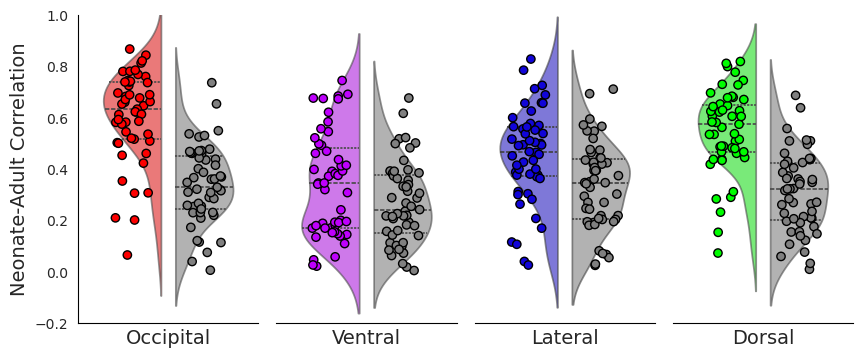

In [65]:
'''
plot sub data at network level
This version compares same to different networks

'''


#remove same region comparisons from df_summary_grouped and df_noise_grouped


#set network order
network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
comp_order = ['same','diff']
#comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


#set network order as categorical and level order
df_network_summary['network_similarity'] = pd.Categorical(df_network_summary['network_similarity'], categories=comp_order, ordered=True)
#df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


#create list of 12 gray colors
network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['#00fd00', 'gray']]

#loop through networks and create subplot for each
#set subplot size
fig,ax = plt.subplots(1,4,figsize=(10,4),sharey=False)
for i in range(0,len(network_order)):
    #print(network_order[i])
    curr_data = df_network_summary[(df_network_summary['network1']==network_order[i]) & (df_network_summary['roi_similarity'] == 'same') | (df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'diff')]
    
    print(curr_data.groupby(['network1','network_similarity'])['fc'].mean())
    
        
    #add horizontal line at mean
    #ax[i].axhline(y=curr_data[curr_data['roi_similarity']=='same']['corr'].mean(), color = 'r', linestyle = '--')
    
    #plot summary_df
    sns.violinplot(data=curr_data, x= 'network1', y= 'fc', hue='network_similarity',
                   split = True,gap = .2, alpha = .6, inner = 'quart', palette = network_colors[i], ax = ax[i])

    #set alpha for all artists
    #for artist in ax[i].artists:
    #    artist.set_alpha(.5)

    sns.stripplot(data = curr_data,  x= 'network1', y= 'fc', hue = 'network_similarity', 
                  dodge=True,edgecolor = 'black', alpha = 1, linewidth=1,jitter = .2, size = 6,
                    palette = network_colors[i], ax = ax[i])




    
    #increase font size of x and y ticks
    #plt.xticks(fontsize = 10)
    #plt.yticks(fontsize = 10)

    #set y limits
    ax[i].set_ylim([-.2,1])

    #add y label
    if i == 0:

        ax[i].set_ylabel('Neonate-Adult Correlation', fontsize = 14)
        #make axes black
        ax[i].spines['left'].set_color('k')
        



    else:
        
        #remove y label
        ax[i].set_ylabel('')
        #remove y ticks
        ax[i].set_yticks([])
        #remove y tick labels
        ax[i].set_yticklabels([])
        #remove y axis line
        ax[i].spines['left'].set_visible(False)

    #remove x ticks and labels
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    
    #add network as xlabel for each subplort
    ax[i].set_xlabel(network_order[i], fontsize = 14)
    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax[i].spines['bottom'].set_color('k')
    

    #remove top and right axes
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    #remove legend
    ax[i].get_legend().remove()

    #print(curr_data.groupby(['infant_network','comparison'])['corr'].mean().reset_index())

plt.subplots_adjust(wspace=.1, hspace=0)

#save 
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation.png', bbox_inches='tight', dpi=300)

In [66]:
sub_df = sub_df[sub_df['age'] <= 1]

df_roi_summary = sub_df.groupby(['roi1', 'roi2','network1','network2','hemi_similarity','roi_similarity']).mean(numeric_only=True).reset_index()

#keep only where hemi_similarity == diff
df_roi_summary = df_roi_summary[df_roi_summary['hemi_similarity'] == 'diff']



Text(0.5, 0, '')

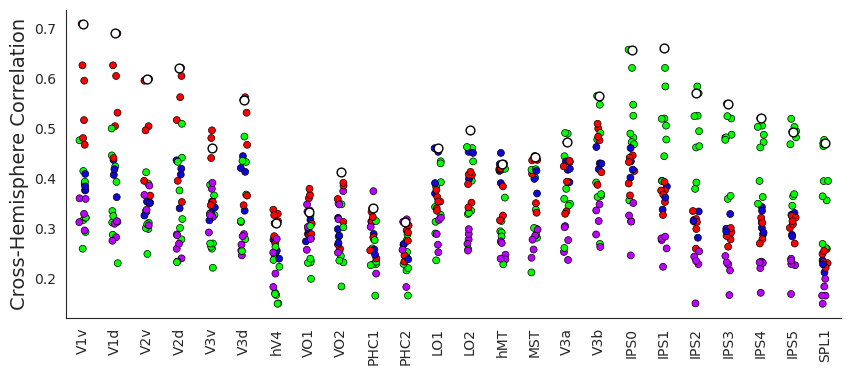

In [67]:
''' plot at ROI level'''

network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']
network_order= ['Occipital','Ventral','Lateral','Dorsal']

#set network order as categorical and level order
df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=roi_labels['label'], ordered=True)
df_roi_summary['network2'] = pd.Categorical(df_roi_summary['network2'], categories=network_order, ordered=True)

df_roi_same = df_roi_summary[df_roi_summary['roi_similarity']=='same']



sns.scatterplot(data = df_roi_same, x = 'roi1', y = 'fc', color = 'white', linewidth = 1, s = 40, edgecolor = 'k', legend = False,zorder = 10)
sns.stripplot(data = df_roi_summary, x = 'roi1', y = 'fc', hue = 'network2', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)


#create scatter plot of noise ceiling
#sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

#remove legend
plt.legend([],[], frameon=False)

#change plot size
plt.gcf().set_size_inches(10,4)

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation_roi.png', bbox_inches='tight', dpi=300)

##### Arealization as function of distance in maps
i.e., assign rois a distance value based on the hierarchy; maybe within pathway

#### Arealization as a function of age

In [9]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')



#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]




# group by hemi_simlarity, roi_similarity, network_similarity
age_df = sub_df.groupby(['sub', 'ses', 'age','age_group','hemi_similarity','roi_similarity','network_similarity', 'network1']).mean(numeric_only=True).reset_index()
#round all values to 4 decimal places
age_df = sub_df.round(4)


#extract only diff hemi_similarity
age_df = age_df[age_df['hemi_similarity'] == 'diff']
#extract only in same network similarity
age_df = age_df[age_df['network_similarity'] == 'same']

#pivot so that sub and network are indices and roi_similarity is columns
age_df = age_df.pivot_table(index = ['sub','ses','age_group','scan_age','birth_age','age','network1'], columns = 'roi_similarity', values = 'fc').reset_index()

#Create new column that is the difference between same and diff
age_df['arealization_index'] = age_df['same'] - age_df['diff']

#save 
age_df.to_csv(f'{git_dir}/results/infant_{atlas}_arealization_index.csv', index = False)

(-0.1, 0.25)

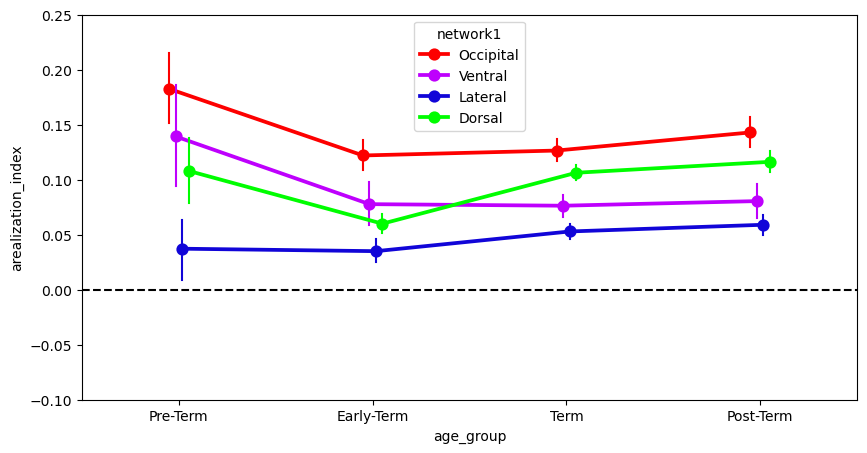

In [14]:
#make age_group categorical
age_df['age_group'] = pd.Categorical(age_df['age_group'], categories=age_groups, ordered=True)
#network categorical
age_df['network1'] = pd.Categorical(age_df['network1'], categories=networks, ordered=True)

#point plot of arealization index
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='arealization_index', data=age_df, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#dotted line at 0
plt.axhline(y=0, color = 'k', linestyle = '--')

plt.ylim(-.1,.25)

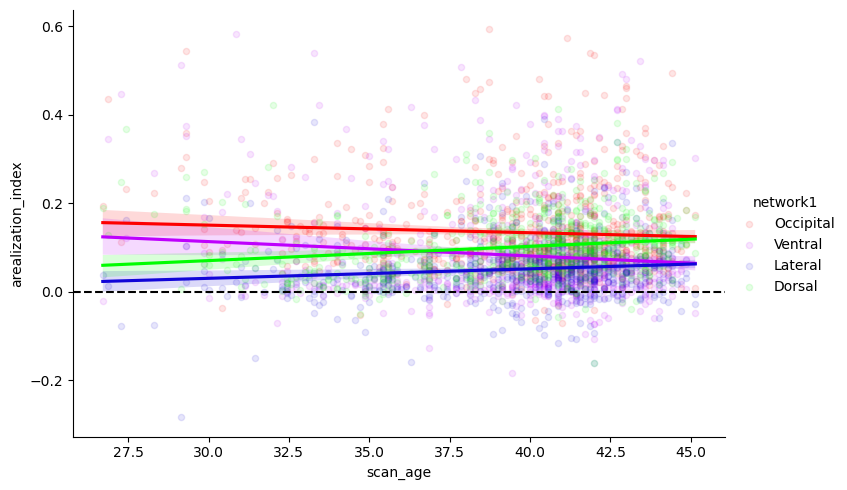

In [150]:
#lmplot of arealization index by scan_age
network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']

#set network order as categorical and level order
age_df['network1'] = pd.Categorical(age_df['network1'], categories=network_order, ordered=True)

sns.lmplot(data = age_df, x = 'scan_age', y = 'arealization_index', hue = 'network1', palette = network_colors, scatter_kws = {'s': 20,  'alpha':.1}, height = 5, aspect = 1.5)

#add dotted line at 0
plt.axhline(y=0, color = 'black', linestyle = '--')





#### Plot controlling for age, or gestation (scan_age)

In [152]:
#regress out age and save residuals in new column
age_df['arealization_age_resid'] = np.nan
age_df['arealization_gestation_resid'] = np.nan
for network in networks:
    #regress out age
    curr_data = age_df[age_df['network1'] == network]
    X = stats.zscore(curr_data['age'])
    y = stats.zscore(curr_data['arealization_index'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    age_df.loc[age_df['network1'] == network, 'arealization_age_resid'] = model.resid
    
    #regress out scan_age
    X = stats.zscore(curr_data['scan_age'])
    y = stats.zscore(curr_data['arealization_index'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    age_df.loc[age_df['network1'] == network, 'arealization_gestation_resid'] = model.resid

   
    

Text(38.726909143518526, 0.5, 'Arealization Index')

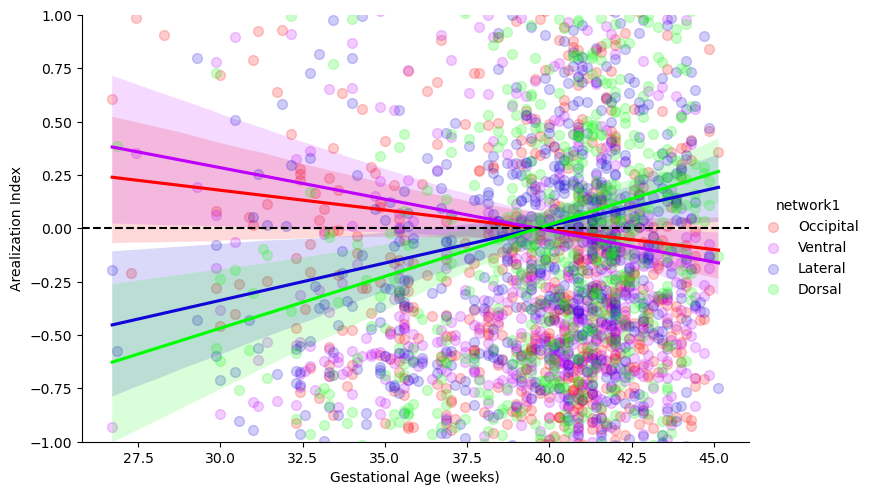

In [162]:
#make lmplots of residuals as a function of gestational age (scan_age), controlling for age since birth
sns.lmplot(data = age_df, x = 'scan_age', y = 'arealization_age_resid', hue = 'network1', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
#dotted line at 0
plt.axhline(y=0, color = 'black', linestyle = '--')

#set ylim
plt.ylim(-1,1)

# set x label to gestational age
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('Arealization Index')

Text(38.726909143518526, 0.5, 'Arealization Index')

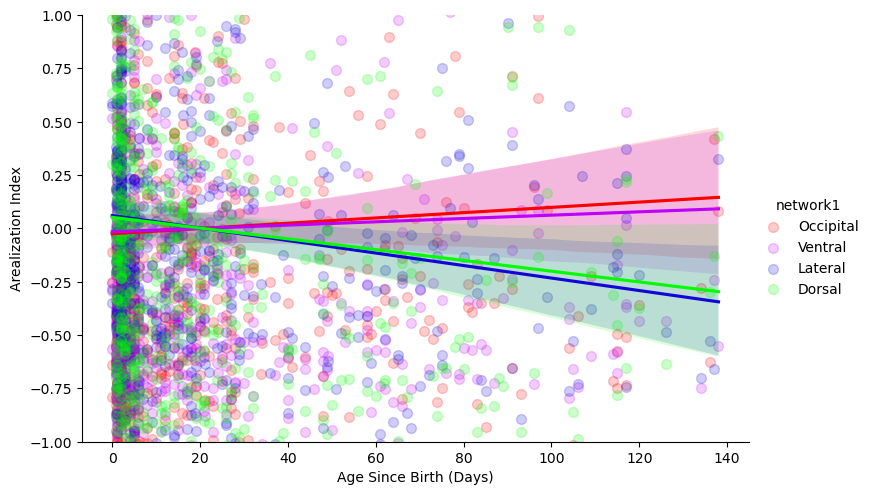

In [163]:
#plot residuals as a function of age since birth controlling for gestational age(scan_age)
sns.lmplot(data = age_df, x = 'age', y = 'arealization_gestation_resid', hue = 'network1', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
plt.ylim(-1,1)

#set X label to age since birth
plt.xlabel('Age Since Birth (Days)')
plt.ylabel('Arealization Index')